In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy.stats import norm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from sklearn import ensemble
from matplotlib import style
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
%matplotlib inline

Загрузка данных

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

Просмотр зависимостей

In [3]:
feature_names = train_data.columns.to_list()
df_feautre_names = train_data.select_dtypes(include=['float64', 'int64'])
num_features = pd.DataFrame(df_feautre_names)

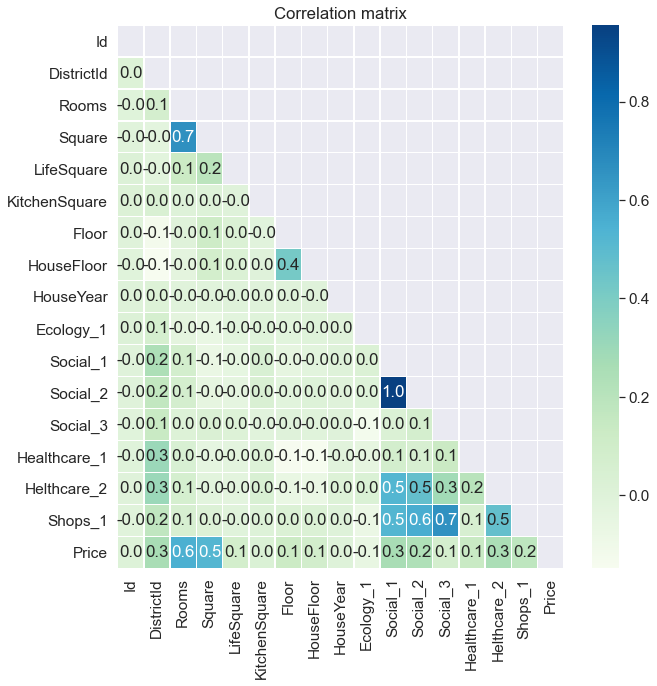

In [4]:
# строим матрицу корреляций
corr = df_feautre_names.corr()
plt.figure(figsize=(10, 10))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.4)
sns.heatmap(df_feautre_names.corr(), mask=mask, annot=True, fmt='.1f', linewidths=0.5, cmap='GnBu')
plt.title('Correlation matrix')
plt.show()

Исследование на выбросы

Цена в зависимости от числа комнат 

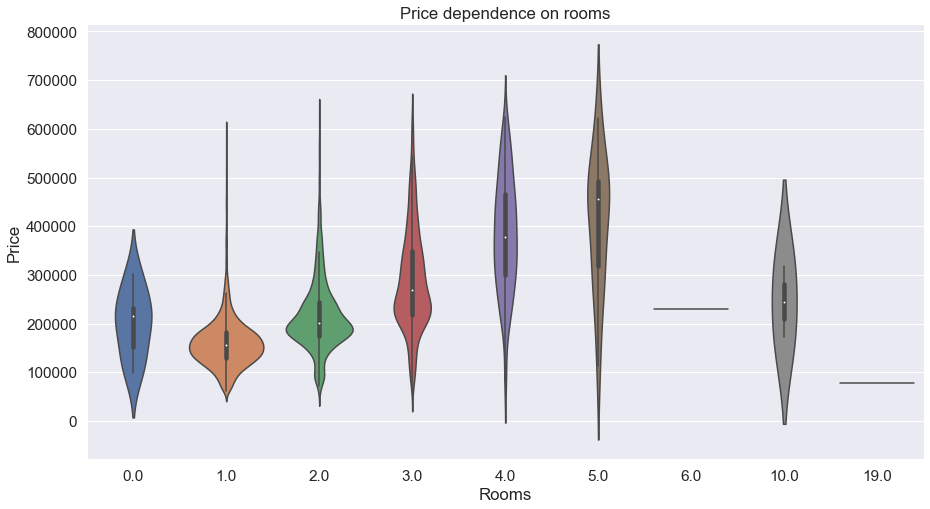

In [5]:
plt.figure(figsize=(15, 8))
sns.violinplot(train_data['Rooms'], train_data['Price'])
plt.xlabel('Rooms')
plt.ylabel('Price')
plt.title('Price dependence on rooms')
plt.show()

Цена в зависимости от площади

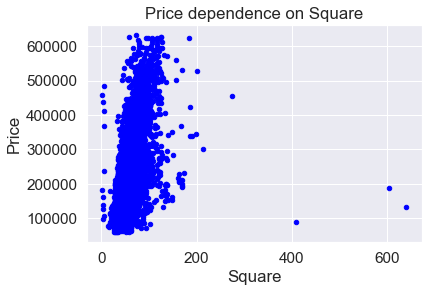

In [6]:
scatter_square = pd.concat([train_data['Price'], train_data['Square']], axis=1)
scatter_square.plot.scatter(x='Square', y='Price', c='Blue' )
plt.title('Price dependence on Square')
plt.show() 

Цена в зависимости от LifeSquare

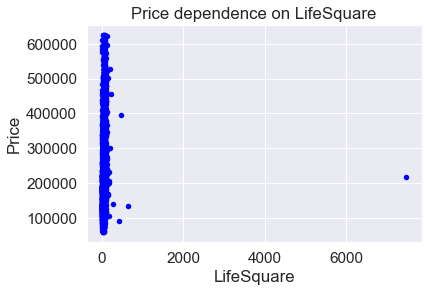

In [7]:
scatter_lifesquare = pd.concat([train_data['Price'], train_data['LifeSquare']], axis=1)
scatter_lifesquare.plot.scatter(x='LifeSquare', y='Price', c='Blue')
plt.title('Price dependence on LifeSquare')
plt.show()

Признаки

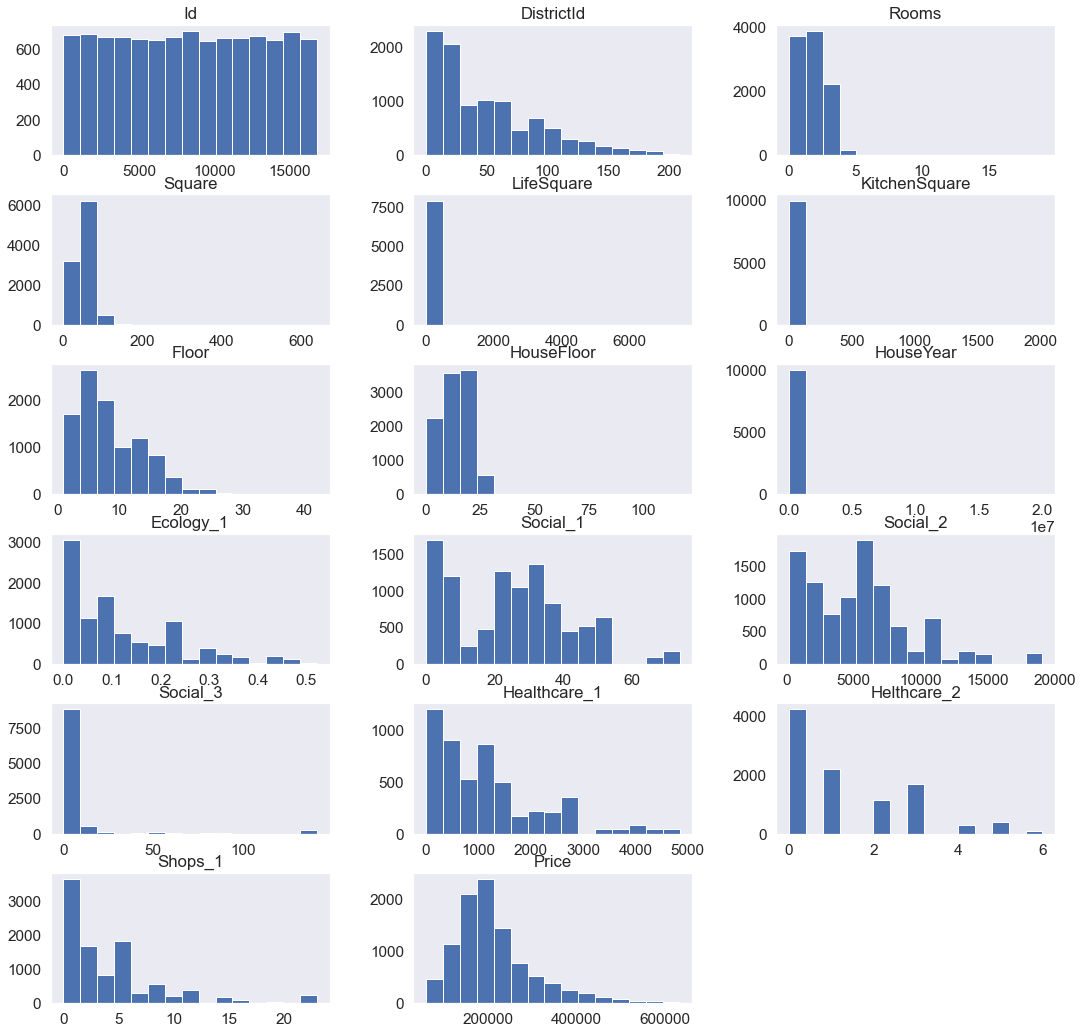

In [8]:
train_features = train_data.select_dtypes(include=['float64', 'int64'])
df_train_features = pd.DataFrame(train_features)
df_train_features.hist(figsize=(18, 18), bins=15, grid=False, layout=(6, 3))
plt.show()



Очистка данных


In [9]:
train_data = train_data.sort_values('Price')

In [10]:
train_data['Rooms'] = train_data['Rooms'].astype('int64')
test_data['Rooms'] = test_data['Rooms'].astype('int64')

In [11]:
train_data['HouseFloor'] = train_data['HouseFloor'].astype('int64')
test_data['HouseFloor'] = test_data['HouseFloor'].astype('int64')

Заполненение пропусков и выбросов

In [12]:
class FeatureImputer:
    # класс для  фичей
    
    def __init__(self):
        
        self.medians = None
        
    def fit(self, df):
        
        self.medians = df.median()
    
    def transform(self, df):
        
        df['Rooms_outlier'] = 0
        df.loc[(df['Rooms'] == 0) | (df['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        df.loc[df['Rooms'] == 0, 'Rooms'] = 1
        df.loc[df['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms'] 
        df.loc[(df['Rooms'] > 5) & (df['Square'] < 50),'Rooms'] = 2
        
        df.loc[df['Square'] < 10,'Square']= df.loc[df['Square'] < 10,'Square'] * 10
        df.loc[df['Square'] < 1,'Square'] = df.loc[df['Square']< 1,'Square'] * 100 
        df.loc[df['Square'] > 250, 'Square'] = self.medians['Square']
        
        df['HouseFloor_outlier'] = 0
        df.loc[df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        
        df.loc[df['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        df.loc[df['KitchenSquare'] > 1000, 'KitchenSquare'] = self.medians['KitchenSquare']
        
        df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        df.loc[df['Floor'] > df['HouseFloor'], 'Floor'] = df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor']
        
        current_year = now = datetime.datetime.now().year
        
        df['HouseYear_outlier'] = 0
        df.loc[df['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        df.loc[df['HouseYear'] > current_year, 'HouseYear'] = self.medians['HouseYear']
        
        if 'Healthcare_1' in df.columns:
            df.drop('Healthcare_1', axis=1, inplace=True)
        
        df.loc[(df['LifeSquare'] > 200) &\
               (df['Square'] < 100),'LifeSquare'] = df.loc[(df['LifeSquare'] > 200) & (df['Square'] < 100),'LifeSquare'] / 10
        
        df['LifeSquare_nan'] = df['LifeSquare'].isna() * 1
        
        clause = (df['LifeSquare'].isna()) &\
                      (~df['Square'].isna()) &\
                      (~df['KitchenSquare'].isna())
        
        df.loc[clause, 'LifeSquare'] = df.loc[clause, 'Square'] * 0.65
        
        
        return df

In [13]:
class FeatureGenerator():
    # генерация фичей(точнее замена A и B в фиче на бинарный тип 0 и 1)
    
    def __init__(self):
        
        self.bin_as_num = None
    
    def fit(self, df):
        
        self.bin_as_num = {'A': 0, 'B': 1}
    
    def transform(self, df):
        
        df['Ecology_2'] = df['Ecology_2'].map(self.bin_as_num)
        df['Ecology_3'] = df['Ecology_3'].map(self.bin_as_num)
        df['Shops_2'] = df['Shops_2'].map(self.bin_as_num)
    
        return df

In [14]:
imputer = FeatureImputer()

imputer.fit(train_data)

train_data = imputer.transform(train_data)
test_data = imputer.transform(test_data)

In [15]:
feature_gen = FeatureGenerator()

feature_gen.fit(train_data)

train_data = feature_gen.transform(train_data)
test_data = feature_gen.transform(test_data)

In [16]:
# заполнение полей NaN
train_data = train_data.fillna(method='pad')
test_data = test_data.fillna(method='pad')



Проверка


In [17]:
y = train_data.Price
train_data.drop("Price", axis=1, inplace=True)
train_data.drop("Id", axis=1, inplace=True)
y

9732     59174.778028
3605     59877.592523
7850     60502.583500
9961     60825.032060
6856     60828.260686
            ...      
3228    624680.099059
4764    625678.644994
1537    625820.041178
8143    627525.072788
6794    633233.466570
Name: Price, Length: 10000, dtype: float64

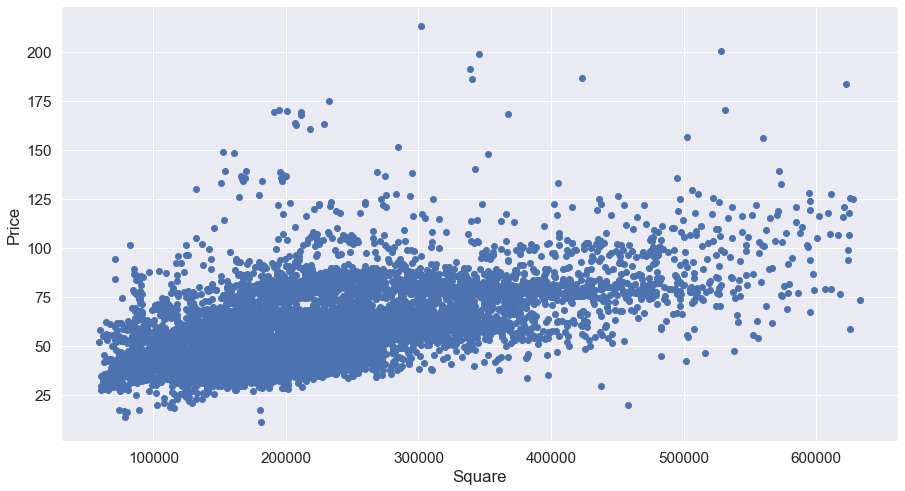

In [18]:
plt.figure(figsize=(15, 8))
plt.scatter(y, train_data.Square)
plt.ylabel('Price')
plt.xlabel('Square')
plt.show()

Модель

In [19]:
train_data = pd.get_dummies(train_data)

In [20]:
model = LGBMRegressor(max_depth=6,
                             num_leaves=12,
                             n_estimators=400,
                             random_state=42)

cros_val = cross_val_score(model, train_data, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# среднее и ошибка
mean = cros_val.mean()
std = cros_val.std()

print(f'R2: {round(mean, 5)} +- {round(std, 5)}')

R2: 0.74716 +- 0.01918


In [21]:
model.fit(train_data, y)

LGBMRegressor(max_depth=6, n_estimators=400, num_leaves=12, random_state=42)

Применение модели и получение предсказаний

In [22]:
X_test = pd.get_dummies(test_data)
X_test.drop("Id", axis=1, inplace=True)

test_data["Price"] = model.predict(X_test)
test_data.loc[:, ['Id', 'Price']].to_csv('1final_prediction.csv', index=False)
test_data.loc[:, ['Id', 'Price']].head(20)

,Id,Price
0,725,162665.543704
1,15856,222928.002351
2,5480,214786.320435
3,15664,356686.308319
4,14275,142753.327558
5,7633,211177.986450
6,13329,173919.584701
7,5502,222043.978068
8,4220,296515.732013
9,11538,187317.376930


In [24]:
test_data.loc[:, ['Id', 'Price']].shape

(5000, 2)